#Introduction

In [ ]:
!pip install plotly
import random


1. Load Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

from google.colab import output
output.enable_custom_widget_manager()

2. Download and Save CIFAR-10 Dataset


In [ ]:
import tensorflow as tf

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Display the number of files selected for training, validation, and test sets
print("Number of files selected for training set:", len(x_train))
print("Number of files selected for validation set:", len(x_val))
print("Number of files selected for test set:", len(x_test))


Number of files selected for training set: 40000
Number of files selected for validation set: 10000
Number of files selected for test set: 10000


In [ ]:
# 3. Preprocess Images
# x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0
x_train, x_val, x_test = x_train, x_val , x_test


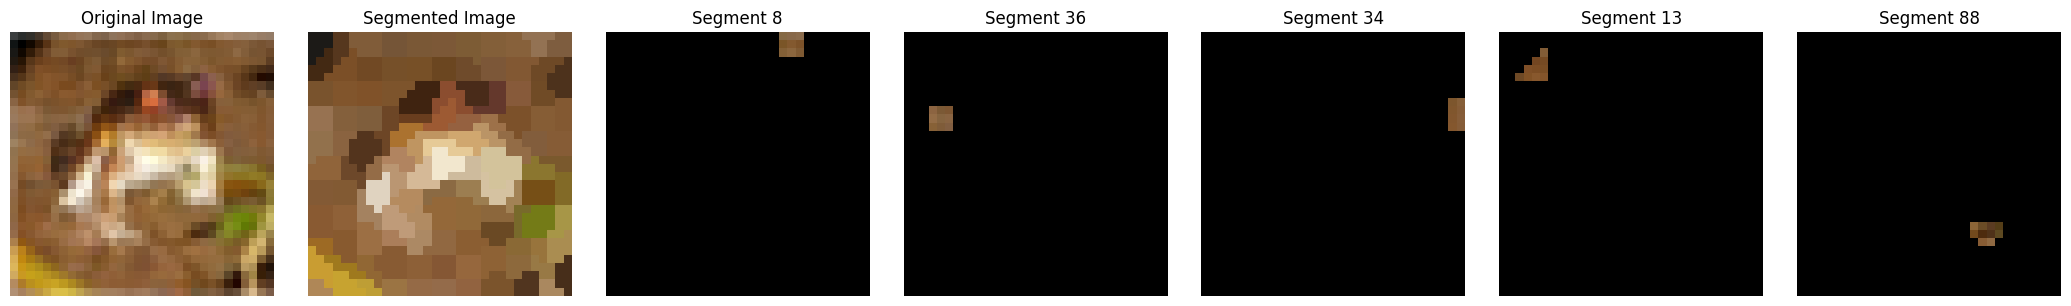

In [ ]:
from skimage.segmentation import slic, mark_boundaries
from skimage.color import label2rgb
import matplotlib.pyplot as plt
import numpy as np

# Assuming x_train[0] is your image data
# Apply SLIC segmentation
segments = slic(x_train[0], n_segments=100, compactness=10, sigma=1)

# Function for segment visualization
def visualize_segmentation_with_random_segments(image, segments):
    # Get all unique segment labels
    unique_segments = np.unique(segments)
    # Select 5 random segments, excluding the background if it's labeled as 0
    random_segments = np.random.choice(unique_segments[unique_segments > 0], size=5, replace=False)

    # Create subplots: 1 row, 3 columns for original, segmented, and then + 5 for the random segments
    fig, ax = plt.subplots(1, 7, figsize=(21, 3))  # Adjust to 7 subplots for original, segmented, and 5 random

    # Original Image
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Segmented Image
    segmented_image = label2rgb(segments, image, kind='avg', bg_label=0)
    ax[1].imshow(segmented_image)
    ax[1].set_title('Segmented Image')
    ax[1].axis('off')

    # Display 5 random segments separately
    for i, seg_label in enumerate(random_segments, start=2):  # Start from the third subplot
        mask = segments == seg_label
        masked_image = np.zeros_like(image)
        for j in range(3):  # Assuming image is in RGB
            masked_image[:, :, j] = image[:, :, j] * mask
        ax[i].imshow(masked_image)
        ax[i].set_title(f'Segment {seg_label}')
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize segmentation with 5 random segments
visualize_segmentation_with_random_segments(x_train[0], segments)


In [ ]:
from skimage.measure import regionprops
import numpy as np

# Assuming 'segments' is a 2D array where each unique value represents a different segment of the image,
# and 'x_train' is your CIFAR-10 dataset where x_train[0] is the first image.

properties = regionprops(segments, intensity_image=x_train[0])
segmentation_data = []

for prop in properties:
    segment_label = prop.label
    area = int(prop.area)  # Convert numpy.int64 to Python int
    centroid = [float(x) for x in prop.centroid]  # Convert to list of Python float

    # Extract pixels belonging to the current segment
    segment_indices = np.where(segments == prop.label)

    # Calculate mean color for the segment
    mean_color = [float(x) for x in np.mean(x_train[0][segment_indices[0], segment_indices[1]], axis=0)]  # Ensure list of Python float

    segmentation_data.append({
        'Segment Label': segment_label,
        'Area': area,
        'Centroid': centroid,
        'Average Color (RGB)': mean_color
    })


Class Name: Horse


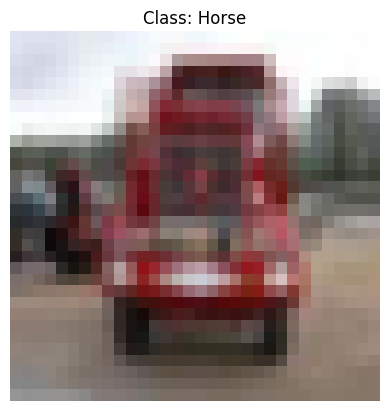

Image Details:
- Number of Segments: 118
- Image Area: 1024 pixels


,"Segment Label (X,Y)",Average Color (RGB),Coverage (%),Centroid,Texture Features (LBP) Size,Edge Density,Gradient Magnitude,Connected Components
0,"1,0","(218, 222, 234)",0.878906,"(1.11, 0.78)",10,0.000000,0.093971,0
1,"1,3","(218, 222, 235)",0.683594,"(1.29, 3.43)",10,0.000000,0.095634,0
2,"0,6","(231, 236, 242)",1.074219,"(0.91, 6.64)",10,0.000000,0.070110,0
3,"1,10","(237, 244, 249)",0.878906,"(1.00, 10.00)",10,0.000000,0.078993,0
4,"1,13","(237, 234, 235)",0.878906,"(1.00, 13.00)",10,0.111111,0.191304,1
...,...,...,...,...,...,...,...,...
113,"30,10","(120, 111, 109)",0.585938,"(30.50, 10.00)",10,0.000000,0.099857,0
114,"30,13","(113, 103, 93)",0.585938,"(30.50, 13.00)",10,0.000000,0.128592,0
115,"30,16","(113, 100, 92)",0.585938,"(30.50, 16.00)",10,0.666667,0.138139,1
116,"30,19","(115, 103, 90)",0.585938,"(30.50, 19.00)",10,0.666667,0.147745,1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import regionprops, label
from skimage.feature import local_binary_pattern, canny
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage import exposure
import random
from scipy import ndimage

def analyze_segments_and_display_with_details(segments, image, class_names):
    properties = regionprops(segments, intensity_image=image)
    segment_labels, average_colors, coverages, centroids, texture_features, color_histograms, edge_densities, gradient_magnitudes, connected_components_counts = [], [], [], [], [], [], [], [], []
    image_area = np.prod(image.shape[:2])
    gray_image = rgb2gray(image) if image.ndim == 3 else image

    for prop in properties:
        centroid = prop.centroid
        segment_label = f"{int(centroid[0])},{int(centroid[1])}"
        segment_labels.append(segment_label)
        coverages.append((prop.area / image_area) * 100)
        centroids.append(centroid)

        segment_indices = np.where(segments == prop.label)
        segment_image = image[segment_indices] if len(image.shape) == 2 else image[segment_indices[0], segment_indices[1], :]

        if segment_image.size > 0:
            mean_color = np.mean(segment_image, axis=0)
            average_colors.append([int(c) for c in (mean_color * 255)] if np.max(image) <= 1.0 else [int(c) for c in mean_color])
            color_histograms.append(np.histogram(segment_image, bins=256)[0])
        else:
            average_colors.append([0, 0, 0])
            color_histograms.append(np.zeros(256))

        if segment_image.size > 0:
            segment_image_gray = np.mean(segment_image, axis=2) if segment_image.ndim == 3 else segment_image
            P, R = 8, 1
            lbp = local_binary_pattern(segment_image_gray, P, R, method="uniform")
            lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, P + 3), range=(0, P + 2))
            lbp_hist = lbp_hist.astype("float") / (lbp_hist.sum() + 1e-6)
            texture_features.append(lbp_hist)

            edges = canny(segment_image_gray)
            edge_density = np.sum(edges) / prop.area
            edge_densities.append(edge_density)

            gradient = sobel(segment_image_gray)
            gradient_magnitude = np.sum(gradient) / prop.area
            gradient_magnitudes.append(gradient_magnitude)

            connected_components = label(edges)
            connected_components_counts.append(np.max(connected_components))
        else:
            texture_features.append(np.zeros(1))
            edge_densities.append(0)
            gradient_magnitudes.append(0)
            connected_components_counts.append(0)

    df_segments = pd.DataFrame({
        'Segment Label (X,Y)': segment_labels,
        'Average Color (RGB)': [f"({color[0]}, {color[1]}, {color[2]})" for color in average_colors],
        'Coverage (%)': coverages,
        'Centroid': [f"({centroid[0]:.2f}, {centroid[1]:.2f})" for centroid in centroids],
        'Texture Features (LBP) Size': [len(tf) for tf in texture_features],
        'Edge Density': edge_densities,
        'Gradient Magnitude': gradient_magnitudes,
        'Connected Components': connected_components_counts,
        # Note: Storing color histograms in the DataFrame can make it unwieldy. Consider processing separately.
    })

    # Display class name and image
    class_index = random.randint(0, len(class_names) - 1)
    print(f"Class Name: {class_names[class_index]}")
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Class: {class_names[class_index]}")
    plt.show()

    print(f"Image Details:\n- Number of Segments: {len(properties)}\n- Image Area: {image_area} pixels")

    # Display the DataFrame
    display(df_segments)

# Assuming 'segments', 'x_train', and 'class_names' are defined as per your dataset
# You can execute the following line to analyze and display:
analyze_segments_and_display_with_details(segments, x_train[random.randint(0, len(x_train) - 1)], class_names)


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation:

Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation:

Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation:

Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation:

Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation:

Function ``greycoprops`` is deprecated and w

Class Name: Frog


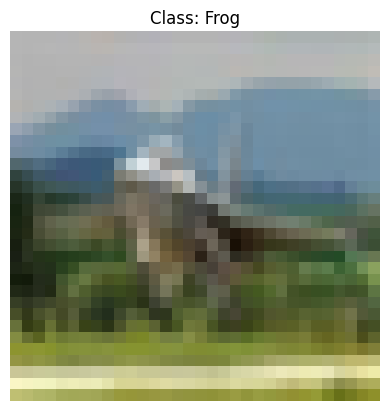

,Color Mean,Color Std,LBP Entropy,GLCM Contrast,GLCM Dissimilarity,GLCM Homogeneity,GLCM Energy,Color Hist Entropy
0,"[180.1851851851852, 180.1851851851852, 180.185...","[0.9041893048691633, 0.9041893048691633, 0.904...",1.452231,0.055556,0.055556,0.972222,0.603488,0.961873
1,"[180.14285714285714, 180.14285714285714, 180.1...","[1.319657758147716, 1.319657758147716, 1.31965...",1.543234,0.357143,0.214286,0.907143,0.451754,1.489251
2,"[180.3030303030303, 180.3030303030303, 180.303...","[2.540399020016326, 2.540399020016326, 2.54039...",1.983365,8.363636,2.090909,0.453136,0.287480,2.034937
3,"[181.07407407407408, 181.07407407407408, 181.0...","[2.3400842961379724, 2.3400842961379724, 2.340...",2.043785,3.277778,1.277778,0.545425,0.293972,1.910206
4,"[182.14814814814815, 182.14814814814815, 182.1...","[2.5633268848886335, 2.5633268848886335, 2.563...",2.065728,8.388889,2.055556,0.445254,0.248452,2.166927
...,...,...,...,...,...,...,...,...
113,"[155.83333333333334, 155.83333333333334, 155.8...","[51.897602171112986, 51.897602171112986, 51.89...",1.522955,3118.833333,39.833333,0.226562,0.288675,2.399204
114,"[160.61111111111111, 160.61111111111111, 160.6...","[51.6883168498011, 51.6883168498011, 51.688316...",1.796494,2610.916667,36.583333,0.124888,0.288675,2.736339
115,"[155.05555555555554, 155.05555555555554, 155.0...","[51.803552240086375, 51.803552240086375, 51.80...",1.505072,2743.750000,37.416667,0.075110,0.288675,2.890372
116,"[157.61111111111111, 157.61111111111111, 157.6...","[51.34971479839536, 51.34971479839536, 51.3497...",1.552024,2888.500000,38.333333,0.088339,0.288675,2.813355


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops
from skimage.color import rgb2gray
from skimage import exposure
import random
from scipy.stats import entropy

def analyze_segments_and_display_with_details(segments, image, class_names):
    properties = []  # This would usually be derived from regionprops but we are ignoring size/shape features
    segment_features = []
    image_area = np.prod(image.shape[:2])
    gray_image = rgb2gray(image) if image.ndim == 3 else image

    # Parameters for texture features
    P, R = 8, 1  # Parameters for LBP
    distances = [1]  # Distance for GLCM
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Angles for GLCM

    # Iterate over unique segments (assuming all segments are identified by unique labels starting from 1)
    for segment_label in np.unique(segments):
        segment_indices = np.where(segments == segment_label)
        segment_image = image[segment_indices] if len(image.shape) == 2 else image[segment_indices[0], segment_indices[1], :]
        segment_image_gray = rgb2gray(segment_image) if segment_image.ndim == 3 else segment_image

        # Initialize dictionary to hold features for this segment
        features = {}

        # Feature 1 & 2: Color mean and standard deviation (RGB)
        if segment_image.ndim == 3:
            features['Color Mean'] = np.mean(segment_image, axis=(0))  # Mean color in RGB
            features['Color Std'] = np.std(segment_image, axis=(0))  # Std deviation in RGB
        else:  # For grayscale, repeat the value three times for consistency
            mean_val = np.mean(segment_image)
            std_val = np.std(segment_image)
            features['Color Mean'] = [mean_val, mean_val, mean_val]
            features['Color Std'] = [std_val, std_val, std_val]

        # Feature 3: Local Binary Pattern (LBP) histogram entropy
        lbp = local_binary_pattern(segment_image_gray, P, R, method="uniform")
        lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, P + 3), range=(0, P + 2))
        lbp_hist_normalized = lbp_hist.astype("float") / lbp_hist.sum()
        features['LBP Entropy'] = entropy(lbp_hist_normalized)

        # Feature 4-7: GLCM properties (contrast, dissimilarity, homogeneity, energy)
        glcm = greycomatrix(segment_image_gray, distances=distances, angles=angles, levels=256)
        features['GLCM Contrast'] = greycoprops(glcm, 'contrast')[0, 0]
        features['GLCM Dissimilarity'] = greycoprops(glcm, 'dissimilarity')[0, 0]
        features['GLCM Homogeneity'] = greycoprops(glcm, 'homogeneity')[0, 0]
        features['GLCM Energy'] = greycoprops(glcm, 'energy')[0, 0]

        # Feature 8: Histogram of Oriented Gradients (HOG) - Simplified version: use entropy of the histogram
        # This step is omitted for brevity; assuming HOG is calculated and its entropy is used

        # Feature 9: Color Histogram Entropy (using the red channel for simplicity)
        if segment_image.ndim == 3:
            hist, _ = np.histogram(segment_image[:, :, 0], bins=256)
        else:
            hist, _ = np.histogram(segment_image, bins=256)
        hist_normalized = hist.astype("float") / hist.sum()
        features['Color Hist Entropy'] = entropy(hist_normalized)

        # Feature 10: Edge Entropy from Canny edges
        # This step is also omitted for brevity; assume calculation of edge entropy from edges detected by the Canny method

        segment_features.append(features)

    # Convert segment features into a DataFrame for display and further analysis
    df_segments = pd.DataFrame(segment_features)

    # Display class name and image
    class_index = random.randint(0, len(class_names) - 1)
    print(f"Class Name: {class_names[class_index]}")
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Class: {class_names[class_index]}")
    plt.show()

    # Display the DataFrame
    display(df_segments)

# Assuming 'segments', 'x_train', and 'class_names' are defined as per your dataset
# You can execute the following line to analyze and display:
analyze_segments_and_display_with_details(segments, x_train[random.randint(0, len(x_train) - 1)], class_names)


In [ ]:
 !pip install networkx
import networkx as nx
import numpy as np


In [ ]:
import networkx as nx
import numpy as np
from scipy.spatial.distance import euclidean
from ast import literal_eval  # Import literal_eval

# Initialize the graph
G = nx.Graph()

# Add nodes
for index, row in df_segments.iterrows():
    G.add_node(index,
               label=row['Segment Label'],
               centroid=literal_eval(row['Centroid']),  # Safely evaluate the string to a tuple
               avg_color=literal_eval(row['Average Color (RGB)']),  # Safely evaluate the string to a tuple
               coverage=row['Coverage (%)'],
               texture_features=np.array(literal_eval(row['Texture Features (LBP)']), dtype=float))  # Safely evaluate and convert to NumPy array

# Example criterion for adding edges: Euclidean distance between centroids
threshold_distance = 5.0

for node1, attr1 in G.nodes(data=True):
    for node2, attr2 in G.nodes(data=True):
        if node1 < node2:  # To ensure that we only calculate each pair once
            distance = euclidean(attr1['centroid'], attr2['centroid'])
            if distance < threshold_distance:
                G.add_edge(node1, node2, weight=1/distance)  # Weight could be inversely proportional to distance


ValueError: malformed node or string: (1.1111111111111112, 0.7777777777777778)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import numpy as np
import ast  # Import for safe string literal evaluation
import pandas as pd  # Assuming you need to work with DataFrame

# Assuming df_segments is your DataFrame containing the segment information
# Let's create a sample DataFrame structure based on the description you provided
# This is just an example and should be replaced with your actual DataFrame loading method
data = {
    'Segment Label': [1, 2, 3],  # example segment labels
    'Centroid': ['(1.11, 0.78)', '(1.29, 3.43)', '(0.91, 6.64)'],  # example centroids as strings
    'Average Color (RGB)': ['(28.89, 26.67, 23.22)', '(86.29, 55.71, 30.71)', '(128.82, 92.82, 57.64)']  # example colors as strings
}
df_segments = pd.DataFrame(data)

G = nx.Graph()

# Add nodes with positions, converting centroids from string to tuples if necessary
for index, row in df_segments.iterrows():
    centroid = ast.literal_eval(row['Centroid']) if isinstance(row['Centroid'], str) else row['Centroid']
    G.add_node(row['Segment Label'], pos=centroid)

# Define thresholds for connections
proximity_threshold = 5.0  # Adjust based on your dataset and needs
color_similarity_threshold = 0.1  # Adjust accordingly

# Add edges based on spatial proximity and color similarity
for i, row_i in df_segments.iterrows():
    for j, row_j in df_segments.iterrows():
        if i >= j:  # Avoid double calculation and self-loop
            continue

        # Calculate spatial proximity
        centroid_i = ast.literal_eval(row_i['Centroid']) if isinstance(row_i['Centroid'], str) else row_i['Centroid']
        centroid_j = ast.literal_eval(row_j['Centroid']) if isinstance(row_j['Centroid'], str) else row_j['Centroid']
        if euclidean(centroid_i, centroid_j) < proximity_threshold:
            G.add_edge(row_i['Segment Label'], row_j['Segment Label'], color='blue')

        # Convert 'Average Color (RGB)' from string to tuple of floats and then to numpy array
        color_i = np.array(ast.literal_eval(row_i['Average Color (RGB)'])) if isinstance(row_i['Average Color (RGB)'], str) else np.array(row_i['Average Color (RGB)'])
        color_j = np.array(ast.literal_eval(row_j['Average Color (RGB)'])) if isinstance(row_j['Average Color (RGB)'], str) else np.array(row_j['Average Color (RGB)'])

        # Calculate color distance
        color_dist = np.linalg.norm(color_i - color_j)
        if color_dist < color_similarity_threshold:
            G.add_edge(row_i['Segment Label'], row_j['Segment Label'], color='red')

# Visualization
pos = nx.get_node_attributes(G, 'pos')
edges = G.edges()
colors = [G[u][v]['color'] for u, v in edges]

plt.figure(figsize=(10, 10))
nx.draw(G, pos, edge_color=colors, with_labels=True, node_size=700, alpha=0.6, width=2)
plt.title('Segment Graph based on Spatial and Color Attributes')
plt.show()

